# LightFM with Recipe Ingredients Clustering
In this notebook, we introduce LightFM, a hybrid recommendation algorithm, and demonstrate its application in a recommendation system where we utilize both user-item interactions and recipe ingredients.

**Hybrid Recommendation Approach**

Traditional recommendation systems often rely solely on user-item interactions, such as user ratings or clicks, to generate recommendations. However, in this notebook, we adopt a hybrid recommendation approach that incorporates additional information beyond user-item interactions.

**Utilizing Recipe Ingredients**

In addition to user-item interactions rated on a scale of 1-5, we enhance our recommendation system by incorporating information about recipe ingredients. Each recipe is represented by a list of ingredients, providing valuable content-based information.

**Recipe Clustering based on Ingredients**

We cluster recipes into 8 meaningful clusters based on their ingredient compositions. Each cluster represents a group of recipes with similar ingredient profiles, enabling the model to capture diverse tastes and preferences among users. By grouping similar recipes together into meaningful clusters, we create item features that capture the inherent structure of the recipe space.

**Item Features in LightFM**

These features allow the model to learn the underlying characteristics of items (recipes) and make more informed recommendations.

**Conclusion**

By integrating user-item interactions with recipe ingredients and clustering recipes into meaningful groups, we create a robust recommendation system that leverages both collaborative filtering and content-based methods. In the following sections, we demonstrate how to train, evaluate, and deploy the LightFM model with recipe ingredients clustering for personalized and accurate recommendations.

In [1]:
import scipy.sparse
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
from lightfm import LightFM
from lightfm.data import Dataset

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
recipes_df = pd.read_csv('filtered_recipes.csv')
interactions_df = pd.read_csv('filtered_interactions.csv')

interactions_df = interactions_df[['user_id', 'recipe_id', 'date', 'rating']]
recipes_df = recipes_df[['name', 'id', 'pp_ingredients']]

In [3]:
# Print initial data sizes
print(f"Initial number of interactions: {interactions_df.shape[0]}")
print(f"Initial number of recipes: {recipes_df.shape[0]}")
print(f"Initial number of users: {interactions_df['user_id'].nunique()}")

Initial number of interactions: 1108856
Initial number of recipes: 226657
Initial number of users: 223316


### 1. Splitting Data into Train and Test Sets
In temporal data, where entries are ordered chronologically, it's crucial to split the dataset carefully to ensure that the training set is used to predict the future and the test set is used to evaluate the model's performance on unseen data, mimicking real-world scenarios where predictions are made for unseen instances.

To split our dataset, we first define a function `split_user_data` to split the interactions of each user. This function divides the user's interactions into two groups: the first half is used for training, and the second half is reserved for testing. 


In [4]:
def split_user_data(group):
    split_idx = int(len(group) * 0.5)
    return group.iloc[:split_idx], group.iloc[split_idx:]

To maintain chronological order, we sort the filtered DataFrame by the 'date' column. Then, we apply the `split_user_data` function defined above.

We filter the test set to remove users and items not seen in the training set. This ensures that our model is evaluated on data that is comparable to what it was trained on.

In [5]:
# Sort the filtered DataFrame by the 'date' column to ensure chronological order
interactions_df.sort_values(by=['user_id', 'date'], inplace=True)

# Apply the split function
split_groups = interactions_df.groupby('user_id').apply(lambda x: split_user_data(x))
train = pd.concat([group[0] for group in split_groups])
test = pd.concat([group[1] for group in split_groups])

# Print sizes after splitting
print(f"Train size: {train.shape[0]}")
print(f"Test size: {test.shape[0]}")

# Filter the test set to remove users and items not seen in the training set
train_users = set(train['user_id'])
train_items = set(train['recipe_id'])
test = test[test['user_id'].isin(train_users) & test['recipe_id'].isin(train_items)]

# Filter test set and print new size
print(f"Filtered test size: {test.shape[0]}")

Train size: 461706
Test size: 647150
Filtered test size: 376841


### 2. Transform our raw data into a COO matrix

We start by extracting unique user and recipe IDs from the training dataset. We then create mappings (`user_map` and `item_map`) that associate each ID with a unique integer index.

Next, we define a function `df_to_coo` that converts a DataFrame to a COO matrix. This function takes the DataFrame, along with the user and item mappings, and converts the user and item IDs to their corresponding integer indices. 

It then converts our train and test data into a COO matrix using these indices and the ratings. The COO matrix represent user-item interactions, where each entry contains the rating given by a user to a particular item.


In [6]:
# Create mappings for user IDs and recipe IDs to integer indices
user_ids = train['user_id'].unique()
user_map = {user_id: i for i, user_id in enumerate(user_ids)}
item_ids = train['recipe_id'].unique()
item_map = {item_id: i for i, item_id in enumerate(item_ids)}

# Function to convert DataFrame to COO matrix
def df_to_coo(df, user_map, item_map):
    user_indices = df['user_id'].map(user_map).astype(int)
    item_indices = df['recipe_id'].map(item_map).astype(int)
    ratings = df['rating']  

    return coo_matrix((ratings, (user_indices, item_indices)), shape=(len(user_map), len(item_map)))

# Convert train and test DataFrames to COO matrices
train_coo = df_to_coo(train, user_map, item_map)
test_coo = df_to_coo(test, user_map, item_map)

### 3. Analyzing user and item distribution in train and test datasets

Here, we combine user and item IDs from both the train and test datasets to get a comprehensive list of all unique user and item IDs.

We filter the recipes DataFrame (recipes_df) to include only the recipes that are present in our combined list of item IDs (all_item_ids). This step ensures that we're working with data that is relevant to our recommendation system.

In [7]:
all_user_ids = pd.concat([train['user_id'], test['user_id']]).unique()
all_item_ids = pd.concat([train['recipe_id'], test['recipe_id']]).unique()
filtered_recipes_df = recipes_df[recipes_df['id'].isin(all_item_ids)]

In [8]:
# Print number of unique users and items
print(f"Number of users in train: {train['user_id'].nunique()}")
print(f"Number of items in train: {train['recipe_id'].nunique()}")

print(f"Number of users in test: {test['user_id'].nunique()}")
print(f"Number of items in test: {test['recipe_id'].nunique()}")

# Total users and items across both datasets
print(f"Total users: {len(all_user_ids)}")
print(f"Total items: {len(all_item_ids)}")

Number of users in train: 59204
Number of items in train: 143814
Number of users in test: 54756
Number of items in test: 87887
Total users: 59204
Total items: 143814


### 4. Extracting Ingredients into One Hot Encoding
This section outlines the process of extracting ingredients into one-hot encoding using custom tokenization.

We define a custom tokenizer function `custom_tokenizer` to process the text data. This function removes unwanted characters like square brackets and single or double quotes, and then splits the text by commas. 

Next, we initialize a CountVectorizer object `vectorizer` with binary encoding. This ensures that each occurrence of an ingredient is represented by a 1, regardless of its frequency.

We apply the CountVectorizer to the `pp_ingredients` column of our DataFrame (`filtered_recipes_df`) to convert the text data into a matrix of one-hot encoded features. This matrix, named `ingredients_matrix`, represents the presence or absence of each ingredient across the recipes.


In [9]:
import re
from sklearn.feature_extraction.text import CountVectorizer

def custom_tokenizer(text):
    # Remove unwanted characters
    text = re.sub(r"[\[\]']", '', text)
    text = re.sub(r'^"|"$', '', text)
    tokens = text.split(', ')
    return tokens

vectorizer = CountVectorizer(tokenizer=custom_tokenizer, lowercase=False, binary=True)

ingredients_matrix = vectorizer.fit_transform(filtered_recipes_df['pp_ingredients'])

feature_names = vectorizer.get_feature_names_out()

# Check the shape and the feature names
print("Shape of ingredients matrix:", ingredients_matrix.shape)
print("Some feature (ingredient) names:", feature_names[100:110])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Shape of ingredients matrix: (143814, 7180)
Some feature (ingredient) names: ['alfredo' 'alfredo sauce' 'alfredo sauce mix' 'all beef wiener'
 'all purpose greek seasoning' 'all-bran cereal' 'all-purpose seasoning'
 'alligator meat' 'allspice' 'allspice berry']


### 5. Elbow Method for Optimal Cluster Count

The Elbow Method is a widely used technique to determine the optimal number of clusters (k) for a given dataset. This method involves plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use. The rationale behind this method is that as more clusters are added, the within-cluster variation reduces. The goal is to choose a small value of k that still has a low within-cluster variation, and the elbow usually represents where we start to have diminishing returns by increasing k.

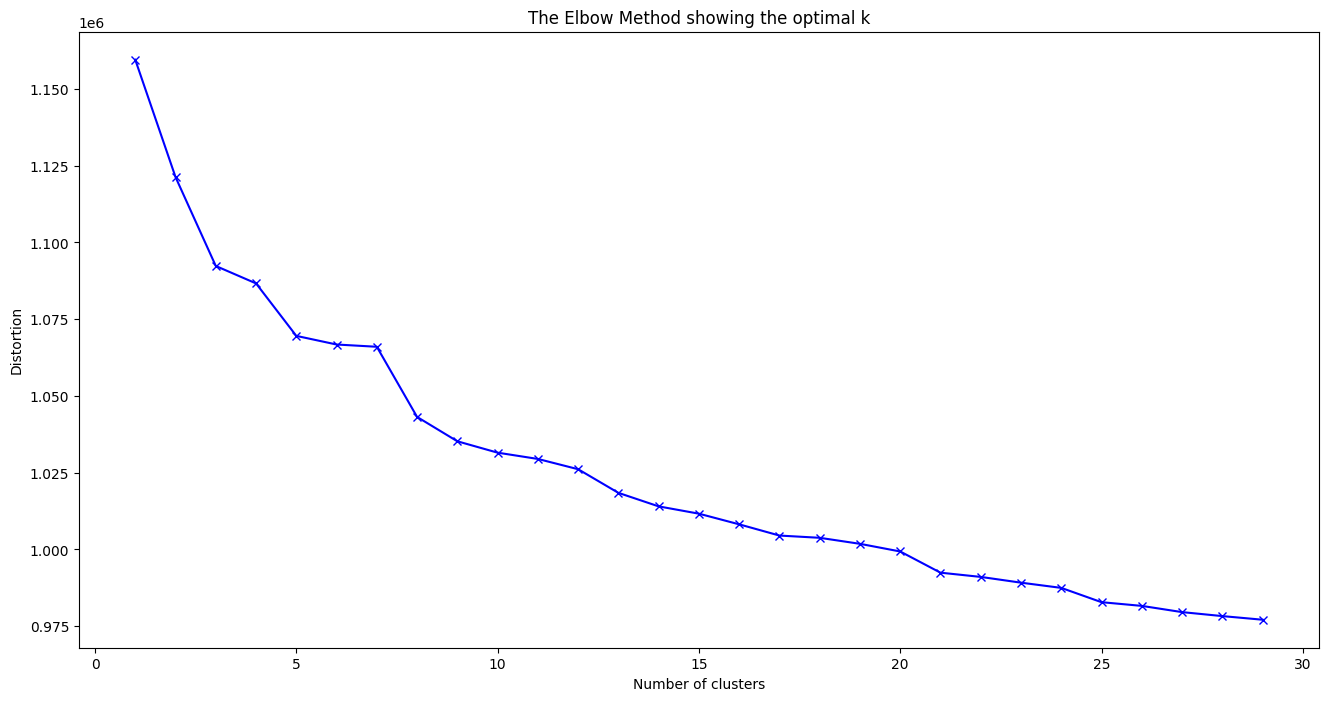

In [10]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Calculate distortions for a range of cluster counts
distortions = []
K = range(1, 30) 
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0)
    kmeanModel.fit(ingredients_matrix)
    distortions.append(kmeanModel.inertia_)

# Plot the elbow
plt.figure(figsize=(16, 8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


### 6. Clustering Analysis with MiniBatchKMeans
Based on the elbow method in the previous section, we determined that 8 clusters would best capture the underlying structure of our data.

Given the size of our dataset, traditional KMeans clustering might be computationally expensive. Therefore, we opted to employ MiniBatchKMeans, a variant of KMeans that processes subsets of the data (mini-batches) rather than the entire dataset at each iteration. This approach is particularly suitable for large datasets, making it more time-efficient while still providing quality clustering results.

We instantiated MiniBatchKMeans with the predetermined 8 clusters, utilised a batch size of 400, and conducted clustering on our dataset of ingredients. Following clustering, we transformed our dataset into a sparse matrix representation where each recipe is represented by its assigned cluster.

In [11]:
from sklearn.cluster import MiniBatchKMeans
from scipy.sparse import lil_matrix, csr_matrix

# Configuration of the number of clusters
num_clusters = 8

# Initialize MiniBatchKMeans with a specified batch size
mini_kmeans = MiniBatchKMeans(n_clusters=num_clusters, batch_size=400, random_state=0, n_init=10, max_iter=300)
mini_kmeans.fit(ingredients_matrix) 

# Preparing clustered features
cluster_labels = mini_kmeans.labels_
clustered_feature_names = [f'cluster_{i}' for i in range(num_clusters)]

# Building a feature matrix where each recipe is represented by its cluster
clustered_matrix = lil_matrix((ingredients_matrix.shape[0], num_clusters), dtype=int)
for i, label in enumerate(cluster_labels):
    clustered_matrix[i, label] = 1  # Set the column corresponding to the cluster to 1

clustered_matrix = clustered_matrix.tocsr()  # Convert to CSR for efficient operations


### 7. Analyzing Ingredient Clusters

After clustering our dataset of ingredients, the next step is to interpret the results. To gain insights into the composition of each cluster, we examine the centroids of the clusters. The centroid of a cluster is a vector of feature values which represents the "center" of the cluster, meaning it is an average of all the points (ingredients in our case) that belong to that cluster.

The 'display_top_ingredients_per_cluster' function takes these centroids and displays the top features (ingredients) that are most representative of each cluster. The number of top features to display is controlled by the 'num_top_ingredients' parameters

For each cluster, the function:
1. Identifies the indices of the top features (those with the highest values in the centroid).
2. Retrieves the names of these top features using the indices.
3. Prints the cluster number and its corresponding top features.
4. Plots these top features and their values in a bar chart for a more visual representation.

Cluster 0: ['veal cutlet', 'heavy cream', 'unsalted butter', 'paprika', 'wild mushroom', 'sherry wine', 'tomato paste', 'dried tarragon', 'olive oil', 'chicken stock']


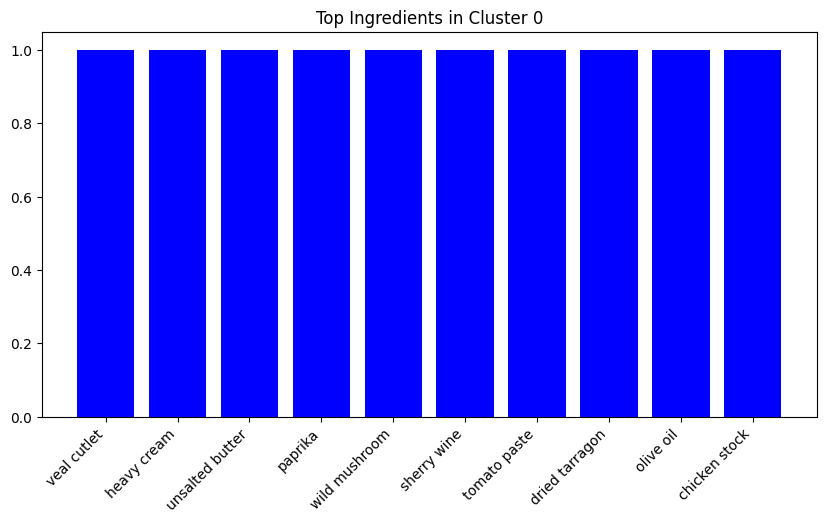

Cluster 1: ['egg', 'butter', 'salt', 'milk', 'sugar', 'baking powder', 'onion', 'water', 'pepper', 'vanilla']


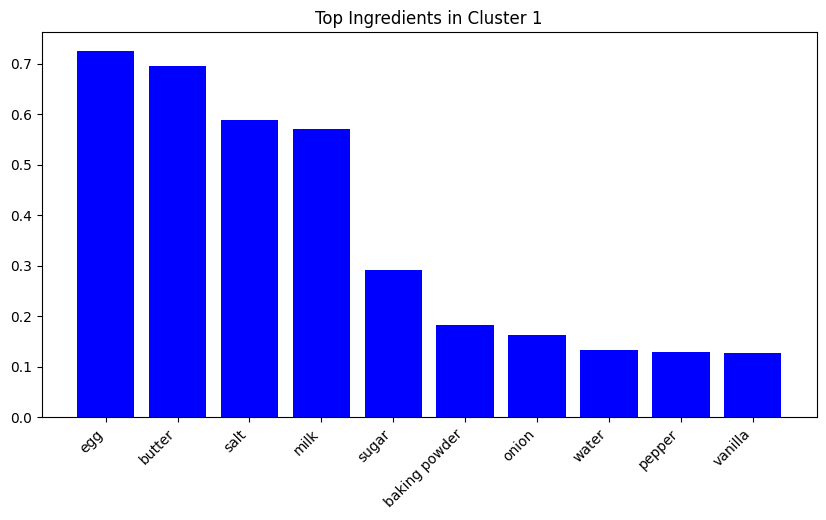

Cluster 2: ['sugar', 'salt', 'water', 'onion', 'butter', 'egg', 'olive oil', 'lemon juice', 'cinnamon', 'garlic clove']


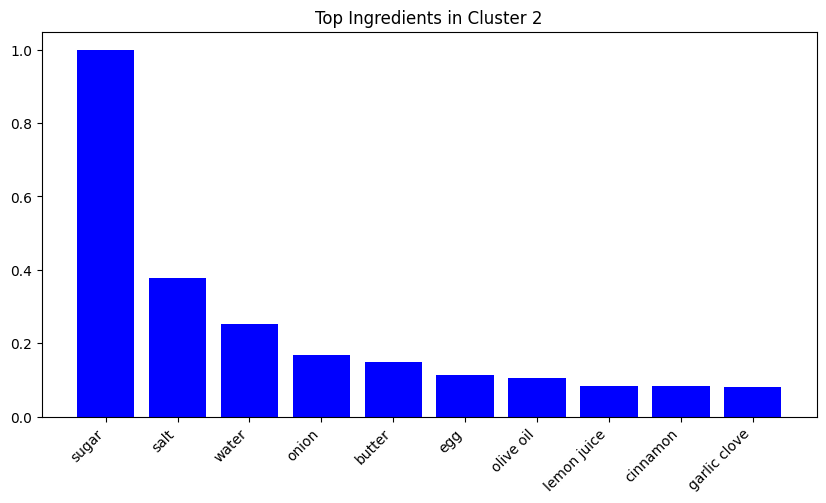

Cluster 3: ['sour cream', 'onion', 'salt', 'cheddar', 'butter', 'pepper', 'tortilla', 'mayonnaise', 'garlic clove', 'cream cheese']


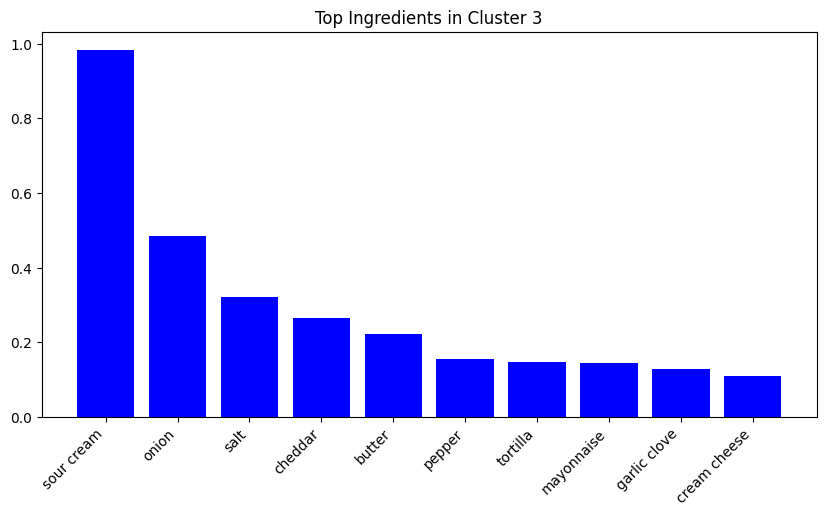

Cluster 4: ['onion', 'salt', 'olive oil', 'garlic clove', 'butter', 'water', 'pepper', 'garlic', 'parmesan cheese', 'salt and pepper']


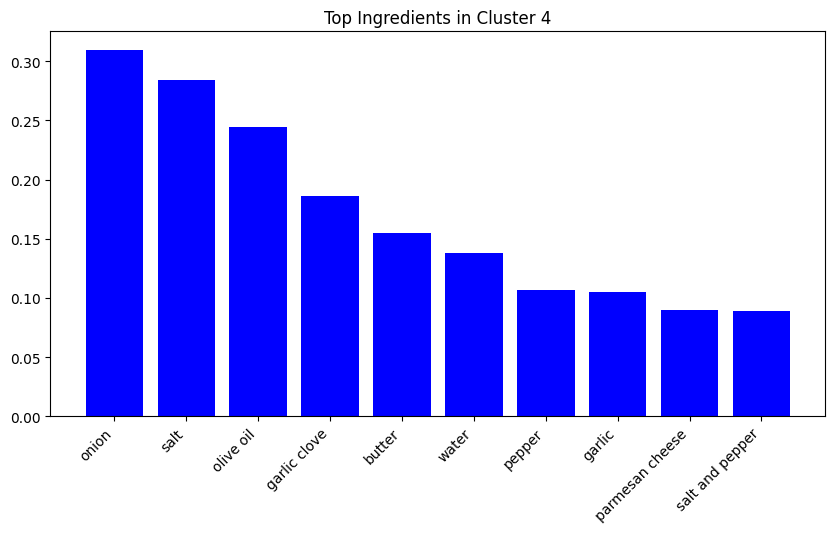

Cluster 5: ['soy sauce', 'honey', 'onion', 'garlic clove', 'salt', 'water', 'olive oil', 'garlic', 'brown sugar', 'sesame oil']


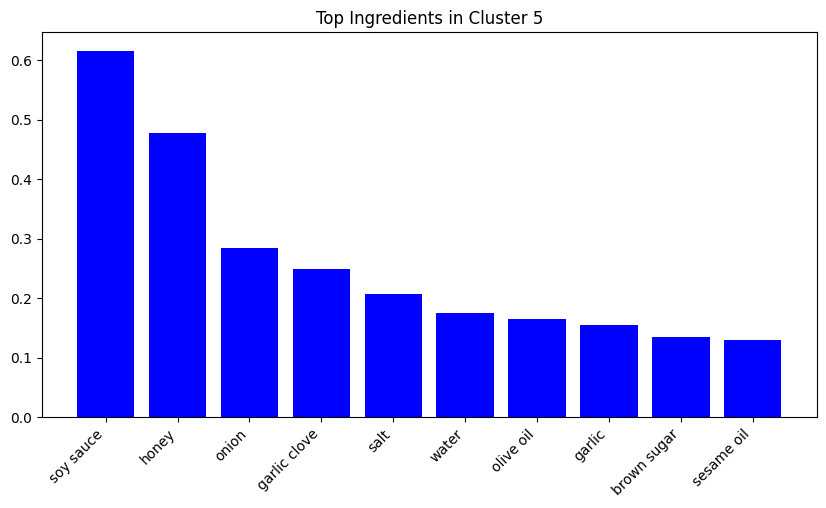

Cluster 6: ['vanilla', 'brown sugar', 'rolled oat', 'egg', 'salt', 'granulated sugar', 'baking powder', 'baking soda', 'firm margarine', 'chocolate-covered english toffee bar']


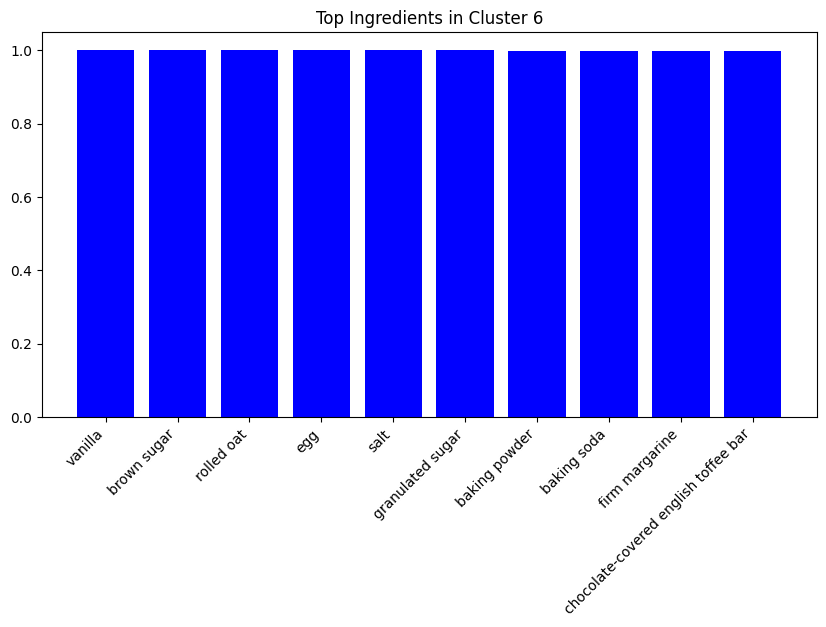

Cluster 7: ['egg', 'salt', 'baking soda', 'baking powder', 'sugar', 'butter', 'vanilla', 'brown sugar', 'cinnamon', 'vanilla extract']


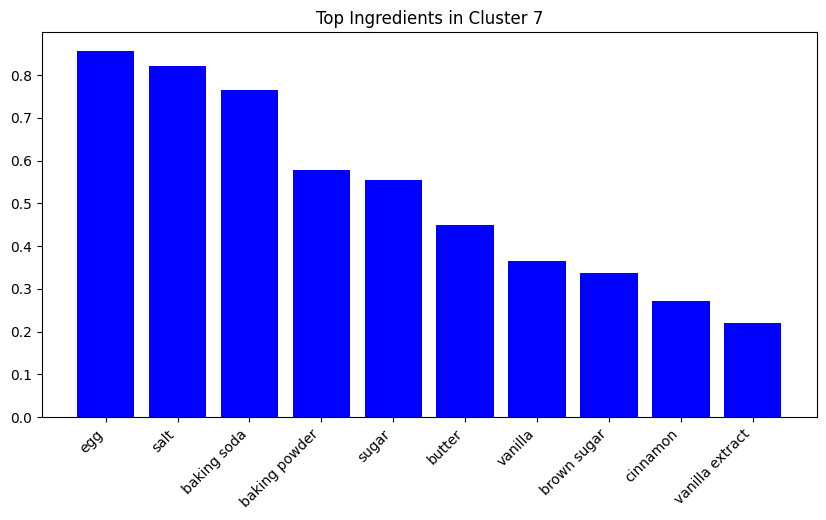

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the centroids if not already available directly
centroids = mini_kmeans.cluster_centers_

# Function to display top ingredients for each cluster
def display_top_ingredients_per_cluster(centroids, feature_names, num_top_ingredients=10):
    for i in range(len(centroids)):
        top_indices = centroids[i].argsort()[-num_top_ingredients:][::-1]
        top_features = [feature_names[idx] for idx in top_indices]
        print(f"Cluster {i}: {top_features}")

        # Optionally plot the top ingredients
        plt.figure(figsize=(10, 5))
        plt.title(f'Top Ingredients in Cluster {i}')
        plt.bar(range(len(top_indices)), centroids[i][top_indices], color='blue')
        plt.xticks(range(len(top_indices)), top_features, rotation=45, ha="right")
        plt.show()

display_top_ingredients_per_cluster(centroids, feature_names)


### 8. Dataset Preparation for LightFM
Here, we prepare the dataset for training a recommendation model using LightFM.

We initialize a `Dataset` object to prepare the dataset for training. We specify the users, items, and item features that will be used in the model.

Next, we prepare the item feature list using the clustered features. Each item ID is associated with its corresponding clustered features.

We build item features using the clustered item feature list. The `build_item_features` method of the dataset object is used for this purpose.


In [13]:
dataset = Dataset()
dataset.fit(
    users=all_user_ids,
    items=all_item_ids,
    item_features=clustered_feature_names  
)

# Prepare the item feature list using the clustered features for LightFM
item_feature_list = [
    (item_id, [f'cluster_{cluster_labels[i]}']) 
    for i, item_id in enumerate(filtered_recipes_df['id'])
]

# Build item features using the clustered item feature list, no normalization
item_features = dataset.build_item_features(item_feature_list, normalize=False)

### 9. Evaluation
Finally, we initialize the LightFM model with specified hyperparameters and fit it to the training data. To ensure our hybrid recommendation system delivers accurate and relevant recipe suggestions, we evaluate the LightFM model using several industry-standard metrics:

- Precision@k:Measures the proportion of recommended recipes in the top-k results that are actually relevant to the user. Higher precision means more of the recommended recipes are useful.

- Recall@k: Assesses the proportion of all relevant recipes that are successfully recommended in the top-k results. Higher recall means the system finds more of the recipes a user would like.

- AUC (Area Under Curve): Evaluates the model’s ability to rank positive interactions higher than negative ones. An AUC closer to 1 indicates better ranking performance.

- RMSE (Root Mean Squared Error): Measures the average difference between the predicted and actual user ratings. Lower RMSE values indicate more accurate predictions.

In [14]:
from lightfm.evaluation import precision_at_k, auc_score, recall_at_k
from sklearn.metrics import mean_squared_error

model = LightFM(learning_rate=0.01, loss='warp')  
model.fit(train_coo,item_features=item_features, epochs=10, num_threads=4)

# Evaluation
train_precision = precision_at_k(model, train_coo, item_features=item_features, k=10).mean()
test_precision = precision_at_k(model, test_coo, item_features=item_features, k=10).mean()
train_recall = recall_at_k(model, train_coo, item_features=item_features, k=10).mean()
test_recall = recall_at_k(model, test_coo, item_features=item_features, k=10).mean()
train_auc = auc_score(model, train_coo, item_features=item_features).mean()
test_auc = auc_score(model, test_coo, item_features=item_features).mean()

print(f"Precision @ k: Train {train_precision:.4f}, Test {test_precision:.4f}")
print(f"Recall @ k: Train {train_recall:.4f}, Test {test_recall:.4f}")
print(f"AUC Score: Train {train_auc:.4f}, Test {test_auc:.4f}")

# Predict ratings for train and test set
train_preds = model.predict(train_coo.row, train_coo.col)
test_preds = model.predict(test_coo.row, test_coo.col)

train_mse = mean_squared_error(train_coo.data, train_preds)
test_mse = mean_squared_error(test_coo.data, test_preds)

print(f"Train MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
